In [1]:
#cargar datos desde drive acceso libre
FILEID = "15QxsIm_jMfHEy6Y--6o19IWgr66oiTRe"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O codigos.zip && rm -rf /tmp/cookies.txt
!unzip codigos.zip
!dir

--2021-09-02 02:02:46--  https://docs.google.com/uc?export=download&confirm=&id=15QxsIm_jMfHEy6Y--6o19IWgr66oiTRe
Resolving docs.google.com (docs.google.com)... 172.217.1.206, 2607:f8b0:4004:806::200e
Connecting to docs.google.com (docs.google.com)|172.217.1.206|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0s-4c-docs.googleusercontent.com/docs/securesc/5ksn1t6556fklra7u28pcgetk54mr1ah/fv77mcginelnt9mkapmu0avm36nd8mif/1630548150000/09173029842254050324/10962340156155868912Z/15QxsIm_jMfHEy6Y--6o19IWgr66oiTRe?e=download [following]
--2021-09-02 02:02:58--  https://doc-0s-4c-docs.googleusercontent.com/docs/securesc/5ksn1t6556fklra7u28pcgetk54mr1ah/fv77mcginelnt9mkapmu0avm36nd8mif/1630548150000/09173029842254050324/10962340156155868912Z/15QxsIm_jMfHEy6Y--6o19IWgr66oiTRe?e=download
Resolving doc-0s-4c-docs.googleusercontent.com (doc-0s-4c-docs.googleusercontent.com)... 142.251.45.1, 2607:f8b0:4004:83e::2001
Connecting to doc-0s-4c-doc

In [2]:
#Paso 1: Lectura

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline


%matplotlib inline
csv_path = 'Main_Fifa/datos/data.csv'

Xdata = pd.read_csv(csv_path)
col_drop = ['Unnamed: 0', 'Name', 'ID', 'Photo','Flag','Club Logo','Loaned From']
Xdata.drop(columns= col_drop, inplace=True)
Xdata.head()


,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Body Type,Real Face,Position,Jersey Number,Joined,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,...,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,31,Argentina,94,94,FC Barcelona,€110.5M,€565K,2202,Left,5.0,4.0,4.0,Medium/ Medium,Messi,Yes,RF,10.0,7/1/2004,2021,5'7,159lbs,88+2,88+2,88+2,92+2,93+2,93+2,93+2,92+2,93+2,93+2,93+2,91+2,84+2,84+2,84+2,91+2,64+2,61+2,61+2,...,59+2,47+2,47+2,47+2,59+2,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,33,Portugal,94,94,Juventus,€77M,€405K,2228,Right,5.0,4.0,5.0,High/ Low,C. Ronaldo,Yes,ST,7.0,7/10/2018,2022,6'2,183lbs,91+3,91+3,91+3,89+3,90+3,90+3,90+3,89+3,88+3,88+3,88+3,88+3,81+3,81+3,81+3,88+3,65+3,61+3,61+3,...,61+3,53+3,53+3,53+3,61+3,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,26,Brazil,92,93,Paris Saint-Germain,€118.5M,€290K,2143,Right,5.0,5.0,5.0,High/ Medium,Neymar,Yes,LW,10.0,8/3/2017,2022,5'9,150lbs,84+3,84+3,84+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,88+3,81+3,81+3,81+3,88+3,65+3,60+3,60+3,...,60+3,47+3,47+3,47+3,60+3,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,27,Spain,91,93,Manchester United,€72M,€260K,1471,Right,4.0,3.0,1.0,Medium/ Medium,Lean,Yes,GK,1.0,7/1/2011,2020,6'4,168lbs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,27,Belgium,91,92,Manchester City,€102M,€355K,2281,Right,4.0,5.0,4.0,High/ High,Normal,Yes,RCM,7.0,8/30/2015,2023,5'11,154lbs,82+3,82+3,82+3,87+3,87+3,87+3,87+3,87+3,88+3,88+3,88+3,88+3,87+3,87+3,87+3,88+3,77+3,77+3,77+3,...,73+3,66+3,66+3,66+3,73+3,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [4]:
Xdata['Age']

0        31
1        33
2        26
3        27
4        27
         ..
18202    19
18203    19
18204    16
18205    17
18206    16
Name: Age, Length: 18207, dtype: int64

In [ ]:
#Paso 2: Particion entrenamiento y validacion
#Tamaño Xtrain 70%, Tamaño Xtest 30%

Xtrain, Xtest = train_test_split(Xdata,test_size=0.3)
col_sal = "Release Clause"
ytrain = Xtrain[col_sal]
ytest = Xtest[col_sal]
Xtrain.drop(columns=col_sal,inplace=True)
Xtest.drop(columns=col_sal,inplace=True)

In [ ]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="most_frequent")
ytrain = imputer.fit_transform(pd.DataFrame(ytrain))
ytrain = ytrain.reshape(-1)

ytest = imputer.transform(pd.DataFrame(ytest))
ytest = ytest.reshape(-1)

print(ytrain.shape, ytest.shape)

(12744,) (5463,)


In [ ]:
ytrain[:5]

array(['€57K', '€11.5M', '€368K', '€455K', '€10.7M'], dtype=object)

In [ ]:
def code_stats(y):
    yc = np.zeros(y.shape[0])
    for i in range(y.shape[0]):
        #print(y.iloc[i])
        
        if y.iloc[i].find("+") > -1: # encontrar signo mas en str y casteo a flotante
            yc[i] = float(y.iloc[i][:y.iloc[i].find("+")])+float(y.iloc[i][y.iloc[i].find("+")+1:])
        else: yc[i] = float(y.iloc[i])
        #print(yc[i])
    return yc   

#codificar moneda ->
def code_euro(y):
    yc = np.zeros(y.shape[0])
    for i in range(y.shape[0]):
      #  print(i,y[i])
        if y[i][-1]=='M': yc[i] = float(y[i][1:-1])*10**6 #buscar M y reemplazar 10^6
        elif y[i][-1]=='K': yc[i] = float(y[i][1:-1])*10**3 # buscar K y reemplazar por 10^3
        else: yc[i] = float(y[i][1:])
        #print(yc[i])
    return yc

In [ ]:
ytrain_num = code_euro(ytrain)
ytest_num = code_euro(ytest)

In [ ]:
ytrain_num[:5]

array([   57000., 11500000.,   368000.,   455000., 10700000.])

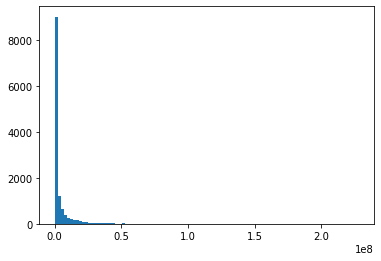

{'boxes': [<matplotlib.lines.Line2D at 0x7f37674d5198>],
 'caps': [<matplotlib.lines.Line2D at 0x7f37674d5ba8>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f37674c9668>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f37674c92e8>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f37674d54a8>,
  <matplotlib.lines.Line2D at 0x7f37674d5828>]}

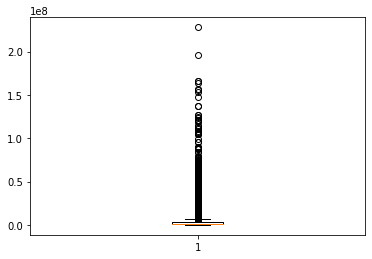

In [ ]:
import matplotlib.pyplot as plt
plt.hist(ytrain_num,bins = 100)
plt.show()

plt.boxplot(ytrain_num)

In [ ]:
col_euro = ['Value','Wage'];
col_stats = ['LS','ST','RS','LW','LF','CF','RF','RW','LAM',
             'CAM','RAM','LM','LCM','CM','RCM','RM','LWB',
             'LDM','CDM','RDM','RWB','LB','LCB','CB','RCB','RB'];

cat = ['Nationality','Club','Body Type','Position','Preferred Foot',
        'Work Rate','Real Face','Contract Valid Until']
items = [] 
for i in cat:
    items += [list(Xdata[i].value_counts().index)]
cat_usr = dict(zip(cat, items))

#dummy = dummy_fifa(col_euro=col_euro,col_stats=col_stats,cat_usr=cat_usr)
#Xtrain_pre = dummy.fit_transform(Xtrain)

In [ ]:
Xdata[cat[3]].value_counts()

ST     2152
GK     2025
CB     1778
CM     1394
LB     1322
RB     1291
RM     1124
LM     1095
CAM     958
CDM     948
RCB     662
LCB     648
LCM     395
RCM     391
LW      381
RW      370
RDM     248
LDM     243
LS      207
RS      203
RWB      87
LWB      78
CF       74
LAM      21
RAM      21
RF       16
LF       15
Name: Position, dtype: int64

In [ ]:
#%% dummy transformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder

class dummy_fifa(BaseEstimator,TransformerMixin):
    #inicializacion de clase y varaibles
    def __init__(self, col_euro,col_stats, cat_usr): #constructor clase
        self.col_euro = col_euro #lista atributos tipo moneda
        self.col_stats = col_stats #lista atributos tipo estadistica
        self.cat_usr = cat_usr #lista de atributos categoricos

    def fit(self,X, *_):
        Xi = X.copy() #copiar dataset para no reemplazar original
        self.imputer_num = SimpleImputer(strategy="most_frequent") #crear imputador tipo modo
        self.a = Xi.columns[np.sum(Xi.isna())> 0] #encontrar columnas con datos faltantes
        #print(a)
        self.imputer_num.fit(Xi[self.a]) # ajustar imputador
        
        Xi[self.a] = self.imputer_num.transform(Xi[self.a]) #evaluar  sobre datos imputador
        #print('Cod Euros\n')
        for i in self.col_euro: #codificar tipo moneda
         #   print(i)
            Xi[i] = code_euro(np.array(Xi[i]))
        #print('Cod stats\n')    
        for i in self.col_stats: #codificar datos estadisticos
         #   print(i)
            Xi[i] = code_stats(Xi[i])
        
        #height, wieght corregir formato
        Xi['Height'].replace(regex=["'"], value='.',inplace=True)        
        for i in Xi.index:
            #print(float(Xi.loc[i,'Weight'][:-3]))
            Xi.loc[i,'Weight'] = float(Xi.loc[i,'Weight'][:-3])
            Xi.loc[i,'Height'] = float(Xi.loc[i,'Height'])
        
        Xi['Height'] = Xi['Height'].astype('float64');#print(Xi['Height'].dtype)
        
        Xi['Joined'] = Xi['Joined'].replace(regex="/",value="")
        Xi['Joined'] = Xi['Joined'].astype('float64')
        
        
        
        cat = [] #codificar variables categoricas con ordinal encoder
        for i in self.cat_usr.keys():
            cat = cat + [[*self.cat_usr.get(i)]]
        self.col_cat_usr = OrdinalEncoder(categories=cat)
        Xi[[*self.cat_usr.keys()]] =self.col_cat_usr.fit_transform(Xi[[*self.cat_usr.keys()]])
        
        #self.col_cat = Xi.columns[Xi.dtypes=='O']
        #self.cod = OrdinalEncoder()
        #self.cod.fit(Xi[self.col_cat])
        
        return self    

    def transform(self, X, *_):#funcion transformador
        Xi = X.copy()
        Xi[self.a] = self.imputer_num.transform(Xi[self.a])
        
        for i in self.col_euro:
         #   print(i)
            Xi[i] = code_euro(np.array(Xi[i]))
        #print('Cod stats\n')    
        for i in self.col_stats:
         #   print(i)
            Xi[i] = code_stats(Xi[i])
        
        #height, wieght
        Xi['Height'].replace(regex=["'"], value='.',inplace=True)        
        for i in Xi.index:
            #print(float(Xi.loc[i,'Weight'][:-3]))
            Xi.loc[i,'Weight'] = float(Xi.loc[i,'Weight'][:-3])
            Xi.loc[i,'Height'] = float(Xi.loc[i,'Height'])
        
        Xi['Height'] = Xi['Height'].astype('float64')
        Xi['Weight'] = Xi['Weight'].astype('float64')
            
        Xi['Joined'] = Xi['Joined'].replace(regex="/",value="")
        Xi['Joined'] = Xi['Joined'].astype('float64')
        
        Xi[[*self.cat_usr.keys()]] =self.col_cat_usr.transform(Xi[[*self.cat_usr.keys()]])
        #Xi[self.col_cat]= self.cod.transform(Xi[self.col_cat])
        return Xi
    
    def fit_transform(self,X,*_):
        self.fit(X)
        return self.transform(X)

In [ ]:
dummy = dummy_fifa(col_euro=col_euro,col_stats=col_stats,cat_usr = cat_usr)
Xtrain_pre = dummy.fit_transform(Xtrain)

In [ ]:
Xtest_pre = dummy.transform(Xtest) # no se puede fit, solo transform